# Detecció d'opinions

In [1]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Edu\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
for cat in mr.categories():
    print(cat, len(mr.fileids(cat)))

neg 1000
pos 1000


In [3]:
def preprocess(review):
    review = review.lower()
    # eliminate any character that is not a letter or a space
    review = ''.join(c for c in review if c.isalpha() or c == ' ')
    review = review.replace('\n', ' ')

    return review

In [33]:
# create a CountVectorizer instance
vectorizer = CountVectorizer()
y = []
corpus = []
for cat in mr.categories():    
    for rev in mr.fileids():
        y.append(cat)
        corpus.append(preprocess(mr.raw(rev)))

In [34]:
print(corpus[1])
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

the happy bastards quick movie review damn that yk bug  its got a head start in this movie starring jamie lee curtis and another baldwin brother  william this time  in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on  little do they know the power within    going for the gore and bringing on a few action sequences here and there  virus still feels very empty  like a movie going for all flash and no substance  we dont know why the crew was really out in the middle of nowhere  we dont know the origin of what took over the ship  just that a big pink flashy thing hit the mir   and  of course  we dont know why donald sutherland is stumbling around drunkenly throughout  here  its just  hey  lets chase these people around with some robots   the acting is below average  even from the likes of curtis  youre more likely to get a kick out of her work in halloween h  sutherland is wasted and baldwin  

## Utilitzant una Multinomial

In [31]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

## Utilitzant Support Vector Machine

In [35]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

## Utilitzant random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=15, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15, random_state=42)

In [36]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.10375


In [42]:
# predict the category of a new review
new_review = "this movie was so good it was amazing"
new_review = preprocess(new_review)
print(new_review)
new_review_vec = vectorizer.transform([new_review])
print(classifier.predict(new_review_vec))

this movie was so good it was amazing
['neg']


              precision    recall  f1-score   support

         neg       0.12      0.11      0.12       422
         pos       0.09      0.09      0.09       378

    accuracy                           0.10       800
   macro avg       0.10      0.10      0.10       800
weighted avg       0.11      0.10      0.10       800



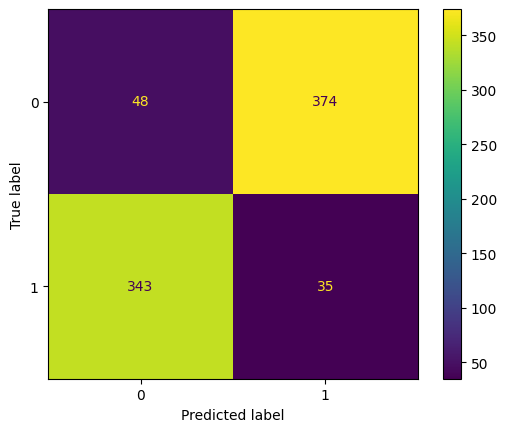

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
results = classifier.predict(X_test)
print(classification_report(y_test, results))
conf_matrix = confusion_matrix(y_test, results)
conf_matrix = ConfusionMatrixDisplay(conf_matrix)
conf_matrix.plot()
plt.show()
